In [18]:
import math
import h5py
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import torch.optim as optim

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

from scipy.signal import detrend
import copy
import re
import torchvision.models as models


2.2.1+cu121


In [19]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 59kB 0 366 731 1096 1461 ... 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 2GB ...

In [20]:
PRECT = pd.read_csv('Detrended_PRECT_reordered.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [21]:
nino = pd.read_csv("Detrended_Nino.csv")
nino

,Sim,year,Average_SST
0,1001.001,1940,0.327026
1,1001.001,1941,0.051076
2,1001.001,1942,1.970464
3,1001.001,1943,-1.860101
4,1001.001,1944,-0.306490
...,...,...,...
7395,1301.020,2009,0.654142
7396,1301.020,2010,1.566384
7397,1301.020,2011,-1.912347
7398,1301.020,2012,-0.929525


# Modeling

### Data Prep

In [22]:
y = PRECT['PRECT'].to_numpy()
y.shape

(22200,)

In [23]:
y = y.reshape(-1, 3)
y = y[:, 1]
y.shape

(7400,)

In [24]:
y_reshaped = y.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [25]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [26]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [27]:
Nino = nino['Average_SST'].to_numpy()
Nino_reshaped = Nino.reshape(100, 74, 1)
Nino_reshaped.shape

(100, 74, 1)

In [28]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [29]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

In [30]:
Nino_train_full, Nino_test = train_test_split(Nino_reshaped, test_size = 0.1, random_state = 49)
Nino_train, Nino_val = train_test_split(Nino_train_full, test_size=.1/.9, random_state=49)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
X_train = from_numpy(X_train).float().to(device)
y_train = from_numpy(y_train).float().to(device)
X_val = from_numpy(X_val).float().to(device)
y_val = from_numpy(y_val).float().to(device)
X_test = from_numpy(X_test).float().to(device)
y_test = from_numpy(y_test).float().to(device)

In [33]:
#Create Dataloader Objects for PyTorch
BATCH_SIZE = 32

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 1])
torch.Size([740, 1])
torch.Size([740, 1])


In [34]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([16, 192, 288])


### Build CNN

In [35]:
### Network Construction
class Net(nn.Module):
    def __init__(self, p):
        super(Net, self).__init__()
        self.p = p
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net(0.3)

In [36]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

12825

### Train CNN to search for best lr and p

In [37]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        #X = X.to(device_cuda, non_blocking=True)
        #y = y.to(device_cuda, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)

def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            #X = X.to(device_cuda, non_blocking=True)
            #y = y.to(device_cuda, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

In [38]:
tuning_valid_losses = []

for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
            
            model = Net(p)
            model.to(device)
            valid_losses = []

            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # 5 epochs didn't give any of them enough to learn anything. Maybe do 10-20?
            epochs = 10
            print(f"Learning Rate: {lr}\nDropout Probability: {p}")
            for t in range(epochs):

                print(f"Epoch {t+1}\n-------------------------------")
                train_loop(dataloader_train, model, loss_fn, optimizer)
                test_valid_loop(dataloader_valid, model, loss_fn)

            # Should we pick the best validation loss or just the most recent?
            
            # Most Recent:
            # tuning_valid_losses.append((valid_losses[epochs -1 ], lr, p))
            
            # Best:
            best_valid_loss = min(valid_losses)

            tuning_valid_losses.append((best_valid_loss, lr, p))
            
print("Done!\n")

Learning Rate: 0.1
Dropout Probability: 0.1
Epoch 1
-------------------------------
loss: 14.598242  [   16/ 5920]
loss: 32.440639  [  592/ 5920]
loss: 58.042423  [ 1168/ 5920]
loss: 42.865589  [ 1744/ 5920]
loss: 48.560246  [ 2320/ 5920]
loss: 48.657337  [ 2896/ 5920]
loss: 35.027832  [ 3472/ 5920]
loss: 51.118328  [ 4048/ 5920]
loss: 18.377806  [ 4624/ 5920]
loss: 69.556290  [ 5200/ 5920]
loss: 53.841862  [ 5776/ 5920]
Validation Loss: 46.379577 

Epoch 2
-------------------------------
loss: 43.052380  [   16/ 5920]
loss: 51.969658  [  592/ 5920]
loss: 51.281441  [ 1168/ 5920]
loss: 34.289108  [ 1744/ 5920]
loss: 56.327629  [ 2320/ 5920]
loss: 39.869926  [ 2896/ 5920]
loss: 47.281464  [ 3472/ 5920]
loss: 57.767231  [ 4048/ 5920]
loss: 49.509163  [ 4624/ 5920]
loss: 34.453644  [ 5200/ 5920]
loss: 26.492950  [ 5776/ 5920]
Validation Loss: 46.294878 

Epoch 3
-------------------------------
loss: 40.752426  [   16/ 5920]
loss: 30.801876  [  592/ 5920]
loss: 52.937771  [ 1168/ 5920]
los

In [39]:
# Pull out best lr and p from above

best_loss = np.inf
for loss, lr, p in tuning_valid_losses:
    if loss < best_loss:
        best_loss = loss
        tuned_lr = lr
        tuned_p = p

print(f"Optimal Learning Rate: {tuned_lr}\nOptimal Dropout Probability: {tuned_p}")

Optimal Learning Rate: 0.001
Optimal Dropout Probability: 0.3


### Training w/ best lr and p

In [40]:
tuned_lr = 0.001
tuned_p = 0.3
model = Net(tuned_p)
model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 100

In [41]:
best_loss = np.inf
patience = 10
no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):
    
    if no_improvement_counter >= patience:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 45.426292  [   16/ 5920]
loss: 46.580070  [  592/ 5920]
loss: 34.219780  [ 1168/ 5920]
loss: 53.833313  [ 1744/ 5920]
loss: 55.934067  [ 2320/ 5920]
loss: 33.545074  [ 2896/ 5920]
loss: 26.710367  [ 3472/ 5920]
loss: 31.397484  [ 4048/ 5920]
loss: 39.508472  [ 4624/ 5920]
loss: 26.754696  [ 5200/ 5920]
loss: 42.998184  [ 5776/ 5920]
Validation Loss: 45.413226 

Epoch 2
-------------------------------
loss: 14.022375  [   16/ 5920]
loss: 48.553581  [  592/ 5920]
loss: 135.243607  [ 1168/ 5920]
loss: 30.855869  [ 1744/ 5920]
loss: 25.466278  [ 2320/ 5920]
loss: 48.654633  [ 2896/ 5920]
loss: 37.699039  [ 3472/ 5920]
loss: 48.331047  [ 4048/ 5920]
loss: 52.684925  [ 4624/ 5920]
loss: 47.735859  [ 5200/ 5920]
loss: 52.014748  [ 5776/ 5920]
Validation Loss: 45.310762 

Epoch 3
-------------------------------
loss: 38.193356  [   16/ 5920]
loss: 35.911842  [  592/ 5920]
loss: 15.735159  [ 1168/ 5920]
loss: 28.993263  [ 1744/ 5920]
loss: 19.697758

In [42]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

actual_values = np.array(y_test.cpu().squeeze(1))

# Instantiate model
model_best_weights = Net(tuned_p)
model_best_weights.to(device)
#model_best_weights = DenseNet(num_classes=1, growth_rate=32, block_config=(6, 12, 24, 16))

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

# Set the model to evaluation mode
model_best_weights.eval()
#model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1)).squeeze(1).detach().cpu().numpy()
#predicted_values = model(X_test.unsqueeze(1)).squeeze(1).detach().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

R-squared: 0.04256540536880493


In [26]:
test_valid_loop(dataloader_test, model_best_weights, loss_fn, valid = False)

Test Loss: 44.029499 



In [27]:
torch.save(model.state_dict(),'North_Final_Weights_Sim.pth')

### Regress PRECT on Nino

In [25]:
Nino_train = Nino_train.reshape(5920, 1)
Nino_test = Nino_test.reshape(740, 1)

In [26]:
linear_mod = LinearRegression()
linear_mod.fit(Nino_train, y_train.cpu())
y_pred = linear_mod.predict(Nino_test)

# Plot Predictions

### Create Predictions Table

In [27]:
pred_dict = dict()
pred_dict2 = dict()
pred_dict3 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940]
    pred_dict2[i] = predicted_values[i - 1940]
    pred_dict3[i] = y_pred[i - 1940]

In [28]:
pred_dict3 = {key: value.item() for key, value in pred_dict3.items()}

In [29]:
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

In [30]:
Nino_pred_df = pd.DataFrame(list(pred_dict3.items()), columns = ['Year', 'Regression PRECT'])

In [31]:
pred_df

,Year,Predicted PRECT
0,1940,1.733588
1,1941,0.950775
2,1942,1.527892
3,1943,-0.126098
4,1944,-1.735034
...,...,...
69,2009,-2.001113
70,2010,-0.866604
71,2011,-1.145510
72,2012,2.506259


In [32]:
Nino_pred_df

,Year,Regression PRECT
0,1940,0.004698
1,1941,0.004111
2,1942,0.008213
3,1943,-0.008488
4,1944,-0.008669
...,...,...
69,2009,0.007255
70,2010,0.000329
71,2011,0.005199
72,2012,-0.005676


In [33]:
actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
# merge actual values and predicted values
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')
actual_pred_df = pd.merge(actual_pred_df, Nino_pred_df, on='Year')

In [34]:
actual_pred_df

,Year,Actual PRECT,Predicted PRECT,Regression PRECT
0,1940,-4.684326,1.733588,0.004698
1,1941,2.021335,0.950775,0.004111
2,1942,14.602043,1.527892,0.008213
3,1943,-9.760468,-0.126098,-0.008488
4,1944,3.969418,-1.735034,-0.008669
...,...,...,...,...
69,2009,0.421508,-2.001113,0.007255
70,2010,-11.057805,-0.866604,0.000329
71,2011,0.386877,-1.145510,0.005199
72,2012,5.838967,2.506259,-0.005676


In [35]:
r_squared_value = r_squared(actual_pred_df['Actual PRECT'], actual_pred_df['Regression PRECT'])
print("Nino R-squared:", r_squared_value)

Nino R-squared: 0.00017992658097054637


### Create plot

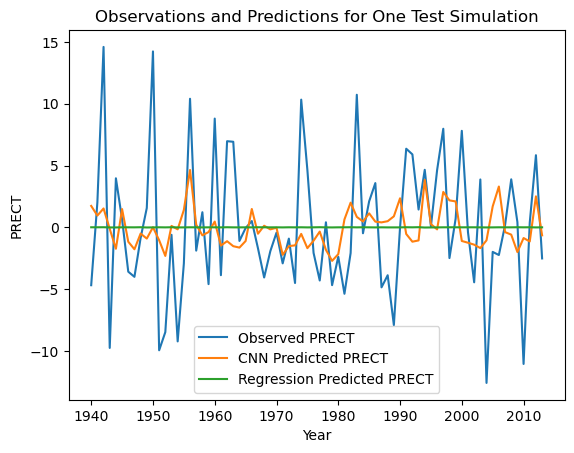

In [36]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='CNN Predicted PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Regression PRECT'], label='Regression Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()

# Plot CNN Losses

In [37]:
train_loss_dict = dict()

valid_loss_dict = dict()

for i in range(len(train_losses)):
    train_loss_dict[i+1] = train_losses[i]
    valid_loss_dict[i+1] = valid_losses[i]

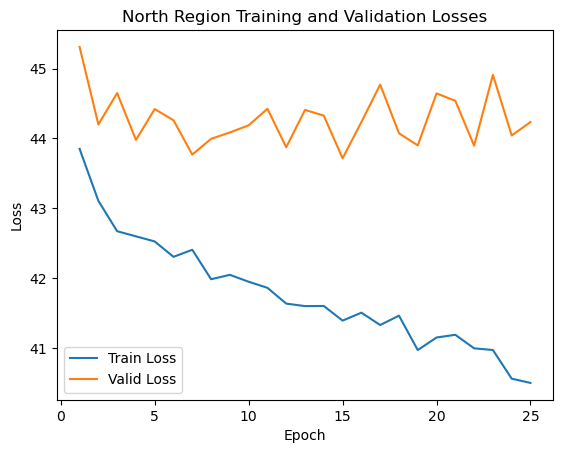

In [39]:
train_loss_df = pd.DataFrame(list(train_loss_dict.items()), columns=['Epoch', 'Train Loss'])
valid_loss_df = pd.DataFrame(list(valid_loss_dict.items()), columns=['Epoch', 'Valid Loss'])

# Merge the DataFrames on 'Epoch' column
merged_df = pd.merge(train_loss_df, valid_loss_df, on='Epoch')

# Plot the losses
plt.plot(merged_df['Epoch'], merged_df['Train Loss'], label='Train Loss')
plt.plot(merged_df['Epoch'], merged_df['Valid Loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('North Region Training and Validation Losses')
plt.legend()
plt.show()

# XAI

In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.crs as ccrs
from captum.attr import Saliency
from captum.attr import visualization as viz
from PIL import Image
import cartopy.io.shapereader as shpreader
from captum.attr import GuidedGradCam

/home/vkr7yx/.local/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


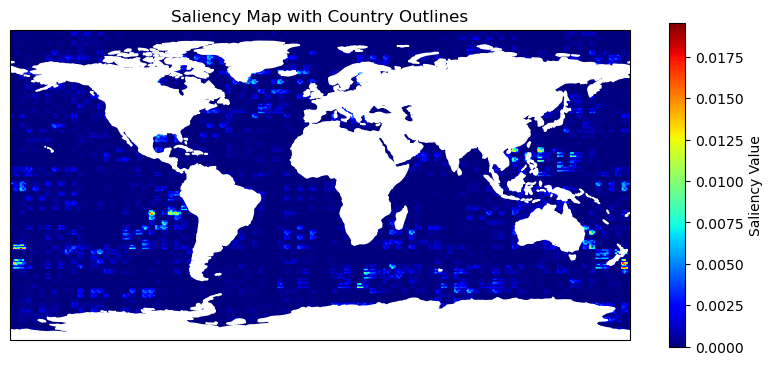

In [44]:
longitude = ds2['lon'].values
latitude = ds2['lat'].values

# Generate a sample input tensor
input_data = X_test[98].unsqueeze(0)

# Create a Saliency object for your model
saliency = Saliency(model_best_weights)

# Compute the saliency map
saliency_map = saliency.attribute(input_data.to(device))

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.flipud(saliency_map_np.squeeze())

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines and fill them in white
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Saliency Value')

plt.title('Saliency Map with Country Outlines')
plt.show()

In [45]:
y_test[98]

tensor([-8.3130], device='cuda:0')

/home/vkr7yx/.local/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/vkr7yx/.local/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


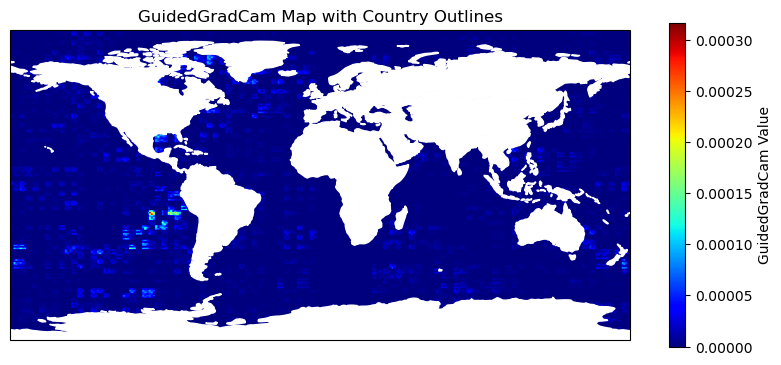

In [46]:
# Generate a sample input tensor
input_data = X_test[98].unsqueeze(0)  # Example input data

# Create a GuidedGradCam object for your model
guided_gradcam = GuidedGradCam(model_best_weights, model_best_weights.conv3)  # Example target layer

# Compute the saliency map
saliency_map = guided_gradcam.attribute(input_data.to(device), 0)

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.mean(np.abs(saliency_map_np), axis=0)
# Flip the saliency map array to match the coordinate system expected by cartopy
saliency_map_np = np.flipud(saliency_map_np)

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('GuidedGradCam Value')

plt.title('GuidedGradCam Map with Country Outlines')
plt.show()

## Potential Resources

https://www.nature.com/articles/s41598-020-57897-9

https://www.nature.com/articles/s41586-019-1559-7 
- first architecture option